# Run level 2A and 2B pipelines on LRS-SLIT data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) August 20th 2017

This notebook demonstrates the execution of the level 2A and 2B pipelines for LRS-SLIT data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

http://ssb.stsci.edu/doc/jwst_dev/jwst/pipeline/index.html

The files used in this notebook is an undithered MIRISim simulation of a point source with a blackbody spectrum plus emission lines. A dedicated background observation is also used for subtraction at the level 2 stage.

#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'LRS-SLIT_demo_data'
input_dir = 'LRS-SLIT_demo_data'
input_file = glob.glob(os.path.join(input_dir,'det*.fits'))[0]

# load all files including the background observation
all_input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the output directory name
output_dir = input_dir + '_test'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_file) as hdulist:
        
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['EXP_TYPE']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print "ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime)
        print "\n\n"
            
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['EXP_TYPE']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print "ID\t Type\t\t\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime)
        print "\n\n"

    # fits extension table
    hdulist.info()

ID	 Type			 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIR_LRS-FIXEDSLIT	 P750L	 FULL	 2	 50	 FAST	 277.5



Filename: LRS-SLIT_demo_data/det_image_1_MIRIMAGE_P750Lexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     147   ()      
  1  SCI           1 ImageHDU        14   (1032, 1024, 50, 2)   float32   
  2  REFOUT        1 ImageHDU        14   (258, 1024, 50, 2)   float32   
  3  PIXELDQ       1 ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  4  PIXELDQ_DEF    1 BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   
  5  ASDF          1 ImageHDU         7   (533679032,)   uint8   


#### show the last frame of the first integration for each file

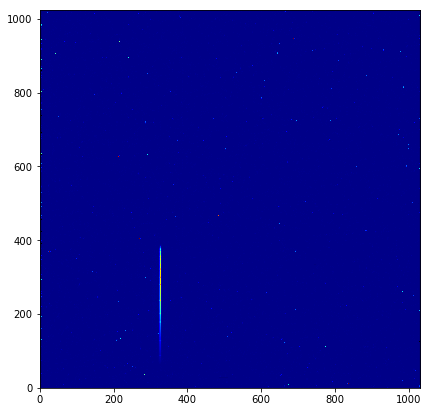

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

with datamodels.open(input_file) as in_dm:
    axs.imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=5e4))
    axs.set_facecolor('black')

plt.tight_layout()
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [5]:
from jwst.pipeline import SloperPipeline
print SloperPipeline.__doc__



    SloperPipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    and ramp_fit.

    


For MIRI, the steps in order are: dq_init, saturation, linearity, RSCD, lastframe, dark_current, refpix, jump, ramp_fitting


#### run pipeline
We pass the level 1B files (demo data). The output level 2A files will be saved in the output_dir as '*_rate.fits'

NOTE: As dark current was switched off in the MIRISim simulations that produced the demo data, we will skip the dark_current step in the call to the SloperPipeline

In [6]:
for input_file in all_input_files:
    dm_2A = SloperPipeline.call(input_file, save_results=True, output_dir=output_dir, steps={'dark_current':{'skip':True}})


2017-08-31 12:00:35,215 - stpipe.SloperPipeline - INFO - SloperPipeline instance created.
2017-08-31 12:00:35,217 - stpipe.SloperPipeline.group_scale - INFO - GroupScaleStep instance created.
2017-08-31 12:00:35,220 - stpipe.SloperPipeline.saturation - INFO - SaturationStep instance created.
2017-08-31 12:00:35,222 - stpipe.SloperPipeline.rscd - INFO - RSCD_Step instance created.
2017-08-31 12:00:35,224 - stpipe.SloperPipeline.ipc - INFO - IPCStep instance created.
2017-08-31 12:00:35,226 - stpipe.SloperPipeline.ramp_fit - INFO - RampFitStep instance created.
2017-08-31 12:00:35,229 - stpipe.SloperPipeline.linearity - INFO - LinearityStep instance created.
2017-08-31 12:00:35,231 - stpipe.SloperPipeline.jump - INFO - JumpStep instance created.
2017-08-31 12:00:35,234 - stpipe.SloperPipeline.refpix - INFO - RefPixStep instance created.
2017-08-31 12:00:35,236 - stpipe.SloperPipeline.lastframe - INFO - LastFrameStep instance created.
2017-08-31 12:00:35,239 - stpipe.SloperPipeline.dq_ini

2017-08-31 12:01:38,069 - stpipe.SloperPipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2017-08-31 12:01:39,293 - stpipe.SloperPipeline.jump - INFO - Executing two-point difference method
2017-08-31 12:01:59,337 - stpipe.SloperPipeline.jump - INFO - Step jump done
2017-08-31 12:01:59,992 - stpipe.SloperPipeline.ramp_fit - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-08-31 12:01:59,993 - stpipe.SloperPipeline.ramp_fit - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-08-31 12:02:00,070 - stpipe.SloperPipeline.ramp_fit - INFO - Step ramp_fit running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x119eb0150>,).
2017-08-31 12:02:00,923 - stpipe.SloperPipeline.ramp_fit - INFO - Using READNOISE reference fil

2017-08-31 12:06:05,193 - stpipe.SloperPipeline.refpix - INFO - use_side_ref_pixels = True
2017-08-31 12:06:05,194 - stpipe.SloperPipeline.refpix - INFO - odd_even_columns = True
2017-08-31 12:06:05,196 - stpipe.SloperPipeline.refpix - INFO - side_smoothing_length = 11
2017-08-31 12:06:05,197 - stpipe.SloperPipeline.refpix - INFO - side_gain = 1.000000
2017-08-31 12:06:05,198 - stpipe.SloperPipeline.refpix - INFO - odd_even_rows = True
2017-08-31 12:06:05,199 - stpipe.SloperPipeline.refpix - INFO - Subtracting initial read from each integration
2017-08-31 12:06:06,637 - stpipe.SloperPipeline.refpix - INFO - Adding initial read back in
2017-08-31 12:06:08,529 - stpipe.SloperPipeline.refpix - INFO - Step refpix done
2017-08-31 12:06:09,225 - stpipe.SloperPipeline.persistence - INFO - Prefetch for PERSAT reference file is 'N/A'.
2017-08-31 12:06:09,226 - stpipe.SloperPipeline.persistence - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2017-08-31 12:06:09,227 - stpipe.SloperPipe

#### Quick check of the pipeline steps applied in the output:

In [7]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print'Check step information status:'
    print 'dq_init: %s' % dm.meta.cal_step.dq_init
    print 'saturation: %s' % dm.meta.cal_step.saturation
    print 'linearity: %s' % dm.meta.cal_step.linearity
    print 'rscd: %s' % dm.meta.cal_step.rscd
    print 'lastframe: %s' % dm.meta.cal_step.lastframe
    print 'dark_current: %s' % dm.meta.cal_step.dark_sub
    print 'refpix: %s' % dm.meta.cal_step.refpix
    print 'jump: %s' % dm.meta.cal_step.jump
    print 'ramp_fit: %s' % dm.meta.cal_step.ramp_fit

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
linearity: COMPLETE
rscd: COMPLETE
lastframe: COMPLETE
dark_current: None
refpix: COMPLETE
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [8]:
from jwst.pipeline import Spec2Pipeline
print Spec2Pipeline.__doc__


    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, photom, resample_spec,
    cube_build, and extract_1d.
    


For the LRS, the level 2B steps in order are: assign_wcs, bkg_subtract, flat_field, srctype, photom, cube_build, extract_1d

The bkg_subtract subtract step requires an association file defining the source and background exposures. At the moment, there is no easy way to create one, so we define it manually in a cell and write to the association json file. 

In [9]:
import json

data = {
    "asn_rule": "Asn_Lv2Spec",
    "asn_pool": "dummy_pool",
    "program": "00000",
    "asn_type": "spec2",
    "products": [
        {
            "name": "lrs_bgsub_1",
            "members": [
                {
                    "expname": "LRS-SLIT_demo_data_test/det_image_1_MIRIMAGE_P750Lexp1_rate.fits",
                    "exptype": "science"
                },
                {
                    "expname": "LRS-SLIT_demo_data_test/bkg_MIRIMAGE_P750Lexp1_rate.fits",
                    "exptype": "background"
                }
            ]
        }
    ]
}

with open('LRS_lvl2_asn.json', 'w') as outfile:  
    json.dump(data, outfile)

#### run pipeline
We pass the level 2 assocation file. The output is contained in the dm_2B data model and saved to a fits file ending in '_cal.fits'.

In [10]:
Spec2Pipeline.call('LRS_lvl2_asn.json', save_results=True, output_dir=output_dir, steps={'extract_1d':{'save_results':True}})


2017-08-31 12:09:47,765 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2017-08-31 12:09:47,768 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.
2017-08-31 12:09:47,770 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2017-08-31 12:09:47,772 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2017-08-31 12:09:47,774 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2017-08-31 12:09:47,776 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.
2017-08-31 12:09:47,778 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2017-08-31 12:09:47,781 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2017-08-31 12:09:47,782 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2017-08-31 12:09:47,784 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2017-08-31 12

2017-08-31 12:09:54,428 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7.1rc2/lib/python2.7/site-packages/asdf/asdftypes.py:262: UserWarning: 'tag:stsci.edu:asdf/transform/shift' with version 1.0.0 found in file 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0023.asdf', but latest supported version is 1.1.0
  warnings.warn(warning_string.format(fname))

2017-08-31 12:09:54,430 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7.1rc2/lib/python2.7/site-packages/asdf/asdftypes.py:240: UserWarning: 'tag:stsci.edu:asdf/transform/shift' with version 1.0.0 found in file 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0023.asdf', but latest supported version is 1.1.0
  warnings.warn(warning_string.format(fname))

2017-08-31 12:09:54,431 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7.1rc2/lib/python2

### check of output

The level 2B pipeline for the LRS produces a background subtracted level 2B (_cal.fits).

We can have a look at the steps applied to this file in the level 2B pipeline

In [11]:
# set the output file names
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))

with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print'Check step information status:'
    print 'assign_wcs: %s' % dm.meta.cal_step.assign_wcs
    print 'bkg_subtract: %s' % dm.meta.cal_step.back_sub
    print 'flat_field: %s' % dm.meta.cal_step.flat_field
    print 'srctype: %s' % dm.meta.cal_step.srctype
    print 'photom: %s' % dm.meta.cal_step.photom


Check step information status:
assign_wcs: COMPLETE
bkg_subtract: COMPLETE
flat_field: COMPLETE
srctype: COMPLETE
photom: COMPLETE


#### plot the spectrum

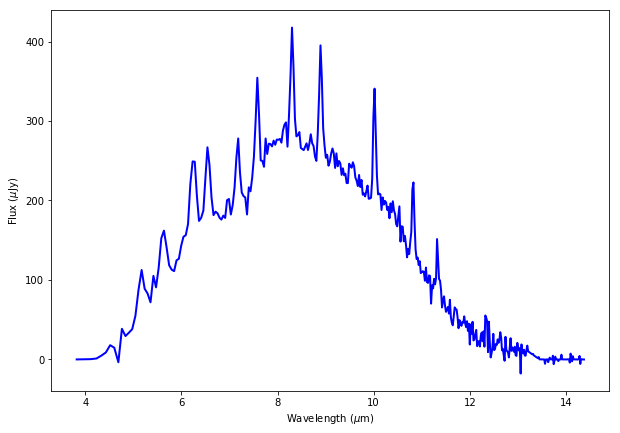

In [12]:
spec_file = glob.glob(os.path.join(output_dir,"*x1d.fits"))[0]
dm = datamodels.open(spec_file)

fig, axs = plt.subplots(1, 1, figsize=(10, 7))

# plot the spectrum 
axs.plot(dm.spec[0].spec_table['WAVELENGTH'][1:-1], dm.spec[0].spec_table['FLUX'][1:-1], c='b', marker='.', 
         markersize=0, linestyle='-', linewidth=2)
axs.set_ylabel(r'Flux ($\mu$Jy)')
axs.set_xlabel(r'Wavelength ($\mu$m)')
#axs.set_xlim(4.9,5.7)
#axs[0].set_ylim(0,6000)


plt.show()